In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import os
import glob
import numpy as np
import pandas as pd

from facerecognition.comparison import One2Many
from facerecognition.inference import FaceRecognition
from facerecognition.utils import (get_frames, find_largest_bbox_index)
from spoofing.metrics import (calculate_eer, calculate_far_frr,
                              evaluate_model, plot_roc, plot_recall_far)

In [113]:
def get_frame_videos(folder, frame_skip=10):
    """
    Extracts frames from video files in a specified folder, skipping a specified number of frames.

    Parameters:
    folder (str): The path to the folder containing the video files.
    frame_skip (int): The number of frames to skip between each frame extraction. Default is 10.

    Returns:
    dict: A dictionary where the keys are the video names (without extension) and the values are lists of extracted frames.
    """
    video_frames = {}
    for video_path in glob.glob(os.path.join(folder, '*.mp4')):
        video_name = os.path.basename(video_path).split('.')[0]
        video_frames[video_name] = get_frames(video_path, frame_skip=frame_skip)
    return video_frames


def get_distance_value(videos):
    """
    Computes the distance value between detected faces in video frames and known embeddings, and compares them to true labels.

    Parameters:
    videos (dict): A dictionary where the keys are video names and the values are lists of frames from the videos.

    Returns:
    pd.DataFrame: A DataFrame containing the computed distances and associated information.
                  The DataFrame columns are:
                  - 'image_name': The name of the image extracted from the video name.
                  - 'i': The frame index.
                  - 'distance': The computed distance value between the detected face embedding and known embeddings.
                  - 'y_pred': The predicted subject ID.
                  - 'y_true': The true subject ID if available, otherwise an empty string.
    """
    values = []
    for video_names, frames in videos.items():
        image_name = video_names.split('real_')[-1].split('_')[0]
        y_true = ''
        if db['image_name'].str.contains(image_name).any():
            y_true = db.loc[db['image_name'].str.contains(image_name), 'subject_id'].values[0]
        for i, frame in enumerate(frames):
            faces, bboxes = face_recognition.detect_faces(frame)
            if len(bboxes) > 0:
                posic = find_largest_bbox_index(bboxes)
                embedding = face_recognition.image_embedding(frame, faces[posic])
                distance, subject_id = one2many.compare(embedding)[0]
                values.append({
                    'image_name': image_name,
                    'i': int(i),
                    'distance': distance,
                    'y_pred': subject_id.split(".")[0],
                    'y_true': y_true
                })
    return pd.DataFrame(values)

## Open DB file csv

In [114]:
db = pd.read_csv('data/db_control.csv')

### Instance classes construtor

In [115]:
face_recognition = FaceRecognition(image_size=160, margin=0,
                                   min_face_size=20, thresholds=[0.6, 0.7, 0.7],
                                   factor=0.709, post_process=True)
one2many = One2Many('bray', 'data/db')

### Read frames from videos

In [ ]:
frames = get_frame_videos('data/videos/real', frame_skip=10)

### Extract the differences from a new frame and the faces in the database

In [ ]:
values = get_distance_value(frames)

## Calculate metrics

In [ ]:
y_scores = np.array(values['distance'])
y_true = (values['y_pred'] == values['y_true'])

In [ ]:
thresholds = np.linspace(min(y_scores), max(y_scores), num=100)
far, frr = calculate_far_frr(y_true, y_scores, thresholds)
eer, best_threshold, posic = calculate_eer(far, frr, thresholds)

# Calculate additional metrics
auc_roc, precision, recall, f1, accuracy = evaluate_model(y_true, y_scores, best_threshold)

print(f'EER: {eer}')
print(f'FAR: {far[posic]}, FRR: {frr[posic]}')
print(f'Best Threshold: {best_threshold}')

print(f'AUC-ROC: {auc_roc}')
print(f'Precision: {precision}, Recall {recall}')
print(f'F1-Score: {f1}, Accuracy {accuracy}')


EER: 0.12702013654826722
FAR: 0.11494252873563218, FRR: 0.13909774436090225
Best Threshold: 0.0872
AUC-ROC: 0.9470995496403845
Precision: 0.7178683385579937, Recall 0.8609022556390977
F1-Score: 0.7829059829059829, Accuracy 0.8789323164918971


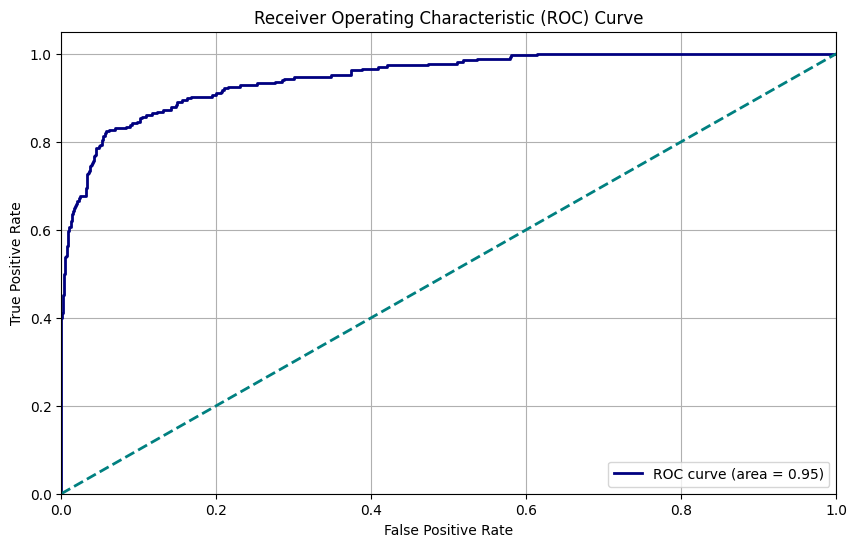

In [ ]:
plot_roc(y_true, y_scores, 'data/results/roc_identification.png')

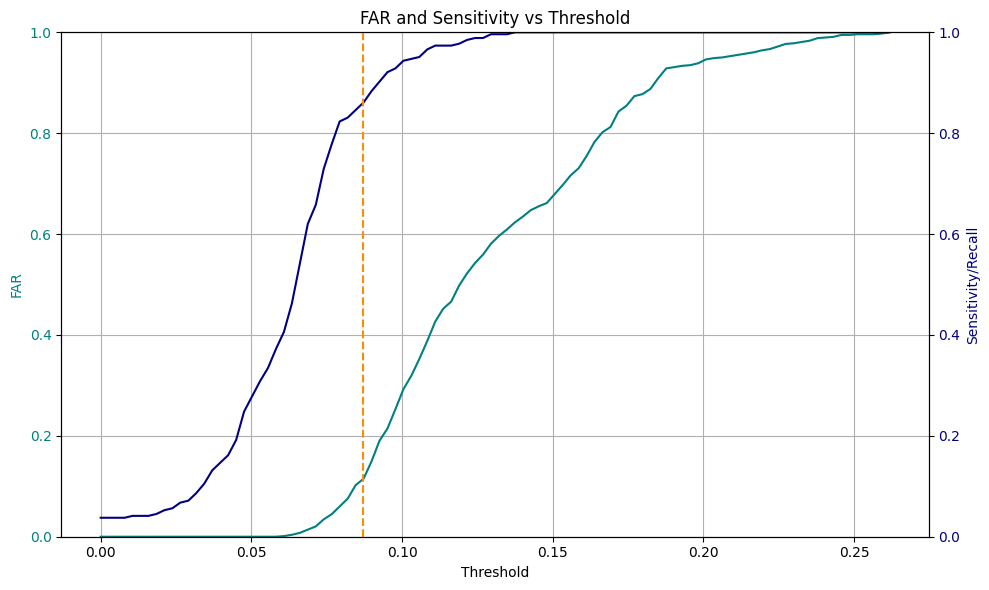

In [ ]:
plot_recall_far(far, frr, thresholds, best_threshold, 'data/results/far_recall_identification.png')